In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_csv("timing_calibration_mintime.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   run       9 non-null      int64  
 1   xpos      9 non-null      float64
 2   tbart     9 non-null      float64
 3   sdt       9 non-null      float64
 4   neventst  9 non-null      int64  
 5   tbarb     9 non-null      float64
 6   sdb       9 non-null      float64
 7   neventsb  9 non-null      int64  
dtypes: float64(5), int64(3)
memory usage: 704.0 bytes


In [4]:
df['dtbart'] = df['sdt']/np.sqrt(df['neventst'])
df['dtbarb'] = df['sdb']/np.sqrt(df['neventsb'])
df['xposoff'] = df['xpos']-25.0
df['dxpos'] = 0.001*df['xpos']

Beta: [-3.74996538e-04 -5.11844386e-02  3.59298802e+00]
Beta Std Error: [0.00011791 0.00163689 0.03758791]
Beta Covariance: [[ 4.44056257e-10 -1.27688854e-09 -1.05059894e-07]
 [-1.27688854e-09  8.55803327e-08 -7.79315110e-09]
 [-1.05059894e-07 -7.79315110e-09  4.51262653e-05]]
Residual Variance: 31.30883458193463
Inverse Condition #: 0.21349046719589115
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (-0.000374997 +/- 0.000117910) X^2 + (-0.051184439 +/- 0.001636894) X + (3.592988020 +/- 0.037587907)
2.188 4.635226148308222
2.531 4.635226148308222
2.888 4.635226148308222
3.222 4.635226148308222
3.59 4.635226148308222
3.905 4.635226148308222
4.236 4.635226148308222
4.493 4.635226148308222
4.47 4.635226148308222
Beta: [-4.09055240e-04 -5.04533627e-02  4.53700780e+00]
Beta Std Error: [0.00014123 0.00198906 0.04476813]
Beta Covariance: [[ 5.27183580e-10 -1.91280219e-09 -1.22951005e-07]
 [-1.91280219e-09  1.04568195e-07  2.51199810e-08]
 [-1.22951005e-07  2.51199810e-

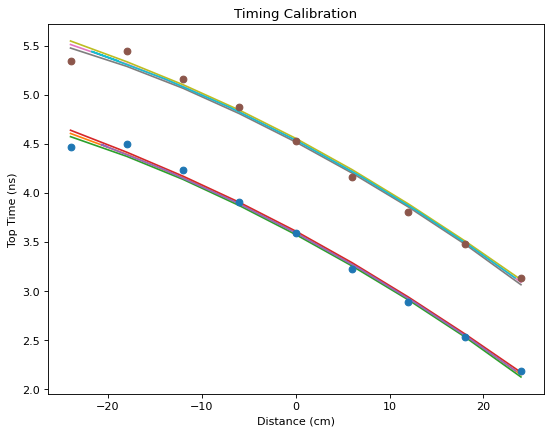

In [9]:
xit = df['xposoff']
yit = df['tbart']
sigmaxit = df['dxpos']
sigmayit = df['dtbart']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x*x + B[1]*x + B[2]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xit, yit, sx=sigmaxit, sy=sigmayit) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[0.01, 0.1, 1.0]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xit) for pi in ps])

lowert = np.percentile(ysample,0.5,axis=0)
uppert = np.percentile(ysample,99.5,axis=0)
middlet = (lowert+uppert)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X^2 + (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xit, yit, xerr=sigmaxit, yerr=sigmayit, fmt='o', capsize=2, capthick=1)

plt.plot(xit,middlet)
plt.plot(xit,lowert)
plt.plot(xit,uppert)

#########################

plt.xlabel('Distance (cm)')
plt.ylabel('Top Time (ns)')
plt.title('Timing Calibration')

a1 = popt[0]
b1 = popt[1]
c1 = popt[2]

xmin = -25.0
ymin = a1*xmin*xmin+b1*xmin+c1-0.003

xplott = yit
yplott = []
for i in range(len(xplott)):
    print (xplott[i],ymin)
    if xplott[i] < ymin:
        yplott.append((-b1-np.sqrt(np.fabs(b1**2-4*a1*(c1-xplott[i]))))/(2.0*a1))
    else:
        yplott.append(-20.0)

plt.plot(yplott,xplott)

xib = df['xposoff']
yib = df['tbarb']
sigmaxib = df['dxpos']
sigmayib = df['dtbarb']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x*x + B[1]*x + B[2]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xib, yib, sx=sigmaxib, sy=sigmayib) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[0.01, 0.1, 1.0]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xib) for pi in ps])

lowerb = np.percentile(ysample,0.5,axis=0)
upperb = np.percentile(ysample,99.5,axis=0)
middleb = (lowerb+upperb)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X^2 + (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

#plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xib, yib, xerr=sigmaxib, yerr=sigmayib, fmt='o', capsize=2, capthick=1)

plt.plot(xib,middleb)
plt.plot(xib,lowerb)
plt.plot(xib,upperb)

#########################

plt.xlabel('Distance (cm)')
plt.ylabel('Top Time (ns)')
plt.title('Timing Calibration')

a2 = popt[0]
b2 = popt[1]
c2 = popt[2]

xmin = -25.0
ymin = a2*xmin*xmin+b2*xmin+c2-0.003

xplotb = yib
yplotb = []
for i in range(len(xplotb)):
    print (xplotb[i],ymin)
    if xplotb[i] < ymin:
        yplotb.append((-b2-np.sqrt(np.fabs(b2**2-4*a2*(c2-xplotb[i]))))/(2.0*a2))
    else:
        yplotb.append(-25.0)

plt.plot(yplotb,xplotb)

plt.show()

In [8]:
print (a1,b1,c1)
print (a2,b2,c2)

-0.00037499653844674384 -0.051184438607694095 3.5929880196450843
-0.0004090552401677775 -0.050453362706664166 4.537007798185197
